---
format: 
  html:
    toc: false
    page-layout: full
execute:
    echo: false
---

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.enums import Resampling
from rasterio.transform import from_origin
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import plotly.express as px
import colorcet as cc
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(42)


Specify input and output directories and color palette

In [2]:
inputs = "/Users/oliveratwood/Documents/GitHub/HotspotStoplight/clustering/data/outputs/crop5c_30m"
outputs = '/Users/oliveratwood/Documents/GitHub/HotspotStoplight/clustering/data/outputs/crop5c_30m'

alignment = '/Users/oliveratwood/Documents/GitHub/HotspotStoplight/LandCoverChange/data/outputs/cropped/crop5c_30m/population.tif'


# Manually specified colors for each category
colors = ['yellow', 'grey', 'blue', 'purple', 'red', 'green']

titles = [
    'OtherProbability',
    'UrbanProbability',
    'population',
    'Flood_Hazards',
    'Heat_Hazards',
    'BII'
]

Load Datasets

In [3]:
# Load the CSV file into a DataFrame
csv_file_path = inputs + '/cluster_2_data.csv'
df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(df.head())

           x          y  OtherProbability  UrbanProbability  population  \
0 -84.482406  10.158081          0.447622          0.000023         0.0   
1 -84.482128  10.158081          0.427885          0.000021         0.0   
2 -84.481851  10.158081          0.382418          0.000021         0.0   
3 -84.481573  10.158081          0.404804          0.000021         0.0   
4 -84.481295  10.158081          0.436384          0.000021         0.0   

   Flood_Hazards  Heat_Hazards       BII  
0       0.018633      0.429480  0.903655  
1       0.018633      0.423849  0.903858  
2       0.026024      0.426188  0.904061  
3       0.067244      0.429235  0.904021  
4       0.065638      0.432249  0.902486  


Standardize the data columns for clustering

In [4]:
# Standardization
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(df[titles])

Perform K-means clustering

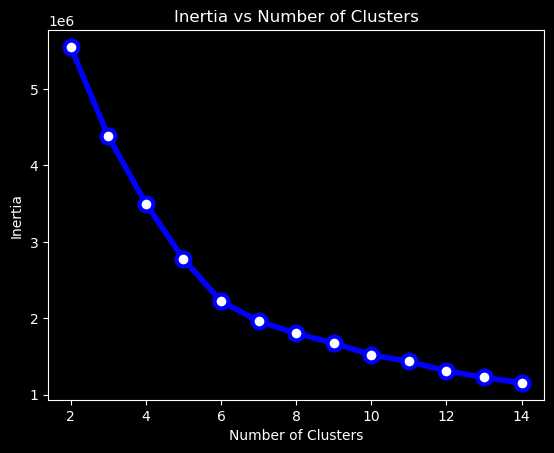

In [5]:
from sklearn.cluster import KMeans

# Number of clusters to try out
n_clusters = list(range(2, 15))

# Run kmeans for each value of k
inertias = []
for k in n_clusters:
    
    # Initialize and run
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=600)
    kmeans.fit(X)
    
    # Save the "inertia"
    inertias.append(kmeans.inertia_)
    
# Plot it!
# Set a dark background style for the plot
plt.style.use('dark_background')

# Plotting the data
plt.plot(n_clusters, inertias, marker='o', ms=10, mfc='white', lw=4, mew=3, color='blue')

# Setting labels and title with light color for visibility
plt.title('Inertia vs Number of Clusters', color='white')
plt.xlabel('Number of Clusters', color='white')
plt.ylabel('Inertia', color='white')

# Display the plot
plt.show()


Determine the appropriate number of clusters using KneeLocator

In [6]:
from kneed import KneeLocator

# Initialize the knee algorithm
kn = KneeLocator(n_clusters, inertias, curve='convex', direction='decreasing')

# Print out the knee 
print(kn.knee)

6


Fit the appropriate number of clusters to the data

In [7]:
# Initialize the Kmeans object
# Using the identified knee
# kmeans = KMeans(n_clusters=(kn.knee), random_state=42, n_init=10)

# Using a manually-assigned knee (optional)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Run the fit! This adds the ".labels_" attribute
kmeans.fit(X);

# Save the cluster labels
df["cluster"] = kmeans.labels_

df.head()

,x,y,OtherProbability,UrbanProbability,population,Flood_Hazards,Heat_Hazards,BII,cluster
0,-84.482406,10.158081,0.447622,0.000023,0.0,0.018633,0.429480,0.903655,2
1,-84.482128,10.158081,0.427885,0.000021,0.0,0.018633,0.423849,0.903858,2
2,-84.481851,10.158081,0.382418,0.000021,0.0,0.026024,0.426188,0.904061,2
3,-84.481573,10.158081,0.404804,0.000021,0.0,0.067244,0.429235,0.904021,2
4,-84.481295,10.158081,0.436384,0.000021,0.0,0.065638,0.432249,0.902486,2


In [8]:
# Count the number of rows for each cluster and sort them to see which clusters have the greatest number of rows
cluster_counts = df['cluster'].value_counts().sort_values(ascending=False)

# Display the counts
print('Number of Pixels per Cluster')
print(cluster_counts)
# print(df.dtypes)

Number of Pixels per Cluster
cluster
0    678485
2    491156
1      1141
Name: count, dtype: int64


Make a multi-bar chart for each cluster

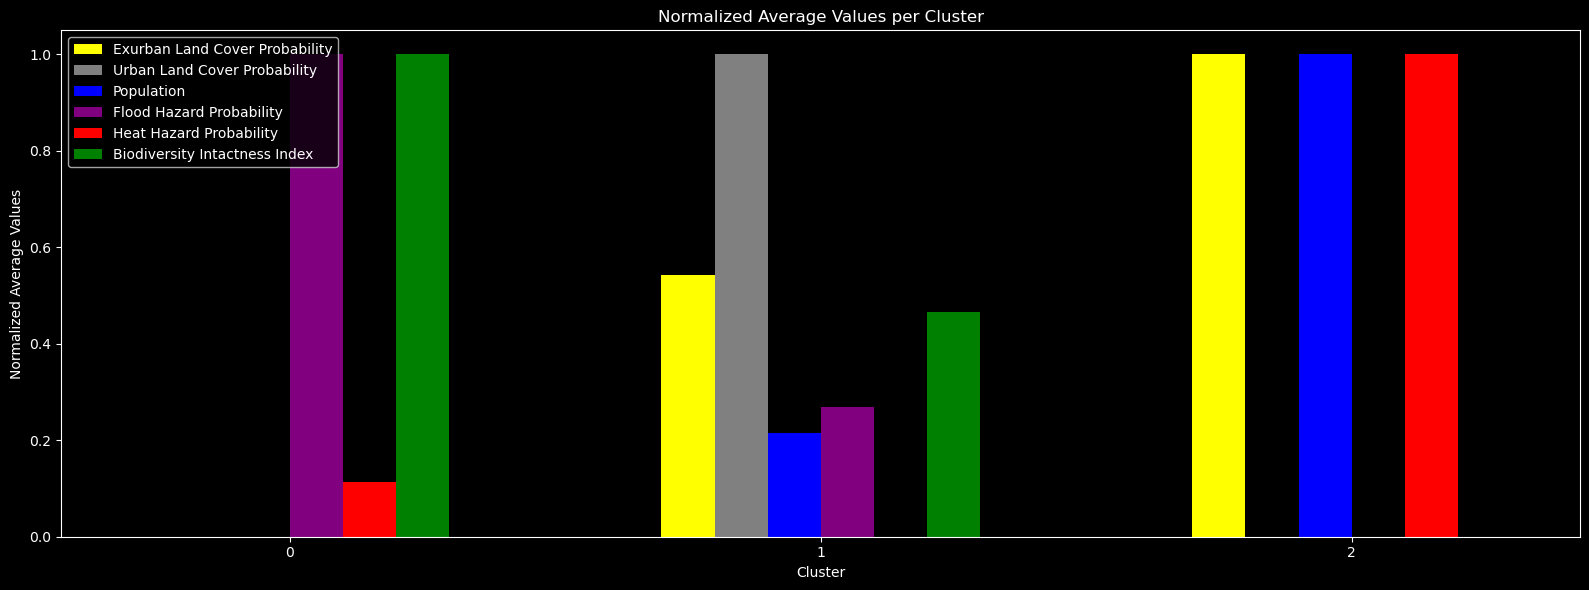

In [9]:
# Group by 'cluster' and calculate mean for each column
cluster_summary = df.groupby('cluster')[titles].mean()

# Normalize the data
cluster_summary_normalized = (cluster_summary - cluster_summary.min()) / (cluster_summary.max() - cluster_summary.min())

# Plotting variables
columns = cluster_summary_normalized.columns
plot_titles = [
    'Exurban Land Cover Probability',
    'Urban Land Cover Probability',
    'Population',
    'Flood Hazard Probability',
    'Heat Hazard Probability',
    'Biodiversity Intactness Index'
]

plt.style.use('dark_background')  # Set dark mode style

fig, ax = plt.subplots(figsize=(16, 6))

# Define the number of groups
n_groups = len(cluster_summary_normalized)

# Define x coordinates for the bars, ensuring they do not overlap
bar_width = 0.1  # Adjusted bar width for better visibility if many groups
indexes = np.arange(n_groups)

# Plotting
for i, (column, title) in enumerate(zip(columns, plot_titles)):
    # Use the corresponding color for each category
    ax.bar(indexes + i * bar_width, cluster_summary_normalized[column], bar_width, label=title, color=colors[i])

ax.set_title('Normalized Average Values per Cluster', color='white')
ax.set_xlabel('Cluster', color='white')
ax.set_ylabel('Normalized Average Values', color='white')
ax.legend()

# Adjust the x-ticks to the middle of the group of bars
ax.set_xticks(indexes + bar_width / 2 * (len(columns) - 1))
ax.set_xticklabels(cluster_summary_normalized.index)

plt.tight_layout()
plt.show()

Here we see how each one of the clusters is composed of a different combination of values of each index we're clustering on.<br>
Let's put together some high-level takeaways about the implications of each of these.<br>
* Land in Clusters 0 is **Biodiversity Assets**, as this means they have a high combination of land cover change probability and biodiversity. The primary difference between these two clusters is that cluster 2 has high flood hazard probability whereas cluster 4 does not.
    * *summary here*
* Land in Cluster 1 is **Biodiversity Loss Risk Zone**. Their low risk level makes conservation a lower prioirty, but minimizing human impact on these lands will help maintain regional biodiversity.
    * *summary here*
* Land in Cluster 3 is the most suitable for **asdf** out of the four clusters, since anthropogenic risk and biodiversity risk are relatively low there.
    * *Low Anthropogenic Risk, Low Biodiversity Risk, High Probability of Urban Land Cover
* Land in Cluster 1 should be considered for **asdf** (NbS) implementation, such as green stormwater infrastructure or tree canopy establishment, either in the form of retrofits or included in areas of new urban development. 
    * *High Anthropogenic Risk, No Biodiversity Risk, High Probability of Urban Land Cover

Plot the clusters across space

/var/folders/2z/nndw55750ksd3hg456d452m80000gn/T/ipykernel_36724/3655701405.py:6: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  scatter = sns.scatterplot(


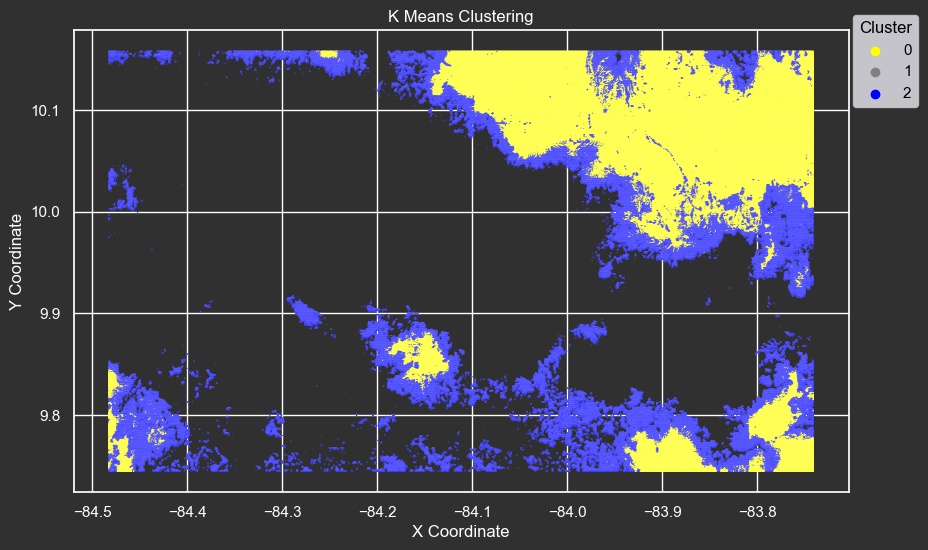

In [10]:
# Set the style of the visualization with a dark background
sns.set(style="darkgrid")

# Create a scatter plot with the custom palette
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x='x', 
    y='y', 
    hue='cluster', 
    palette=colors, 
    data=df, 
    s=0.5  # Point size
)

# Adding title and labels with a light color for visibility against the dark background
plt.title('K Means Clustering', color='white')
plt.xlabel('X Coordinate', color='white')
plt.ylabel('Y Coordinate', color='white')

# Change the color of ticks and labels for visibility
plt.xticks(color='white')
plt.yticks(color='white')

# Modify legend for better visibility on dark background
legend = plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.1, 1.05), frameon=True)
plt.setp(legend.get_texts(), color='black')  # Set the legend text color
plt.setp(legend.get_title(), color='black')  # Set the legend title color

# Set the face and edge color of the figure to match the dark theme
plt.gcf().set_facecolor('#303030')
plt.gca().set_facecolor('#303030')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['bottom']. set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['right'].set_color('white')

# Display the plot
plt.show()

Cluster 0, shown in RED is the zone at highest risk of biodiversity loss.
Prioritization: Conservation

Cluster 1, shown in GREEN is the zone where development risk is low and the suitability of urban development is high. 

Cluster 2

Cluster 3...


In [11]:
# Open the raster dataset and read its bounds and resolution
with rasterio.open(alignment) as dataset:
    bounds = dataset.bounds
    resolution_x, resolution_y = dataset.res  # Resolution in units of the dataset's CRS
    crs = dataset.crs  # Coordinate Reference System of the original raster

transform = dataset.transform

# Use the bounds from the original raster for setting up your analysis
x_min, x_max = bounds.left, bounds.right
y_min, y_max = bounds.bottom, bounds.top

# Assuming that the resolution is uniform in both directions, or choosing one as standard
resolution = resolution_x  # or resolution_y, if different and more appropriate


# Calculate grid dimensions correctly, adding 1 to ensure coverage
width = int(np.ceil((x_max - x_min) / resolution))
height = int(np.ceil((y_max - y_min) / resolution))

# Initialize grid with a nodata value
grid = np.full((height, width), -9999)  # Nodata value

# Assign cluster values to the grid
for _, row in df.iterrows():
    x_idx = int((row['x'] - x_min) / resolution)
    y_idx = int((row['y'] - y_min) / resolution)
    # Ensure indices are within bounds
    if 0 <= x_idx < width and 0 <= y_idx < height:
        grid[height - 1 - y_idx, x_idx] = row['cluster']  # Flip y-axis to match image coordinates

# Correct the CRS specification using a valid EPSG code
crs = "EPSG:4326"  # WGS84 Latitude/Longitude system

# Define geospatial metadata including the corrected CRS
meta = {
    'driver': 'GTiff',
    'dtype': 'float32',
    'nodata': -9999,
    'width': width,
    'height': height,
    'count': 1,
    'crs': crs,  # Corrected CRS specification
    'transform': transform
}

# Specify the filename
filename = 'cluster2subclusters.tif'

# Concatenate the directory and filename to get the full output path
output_path = outputs + filename

# Save to GeoTIFF
with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(grid.astype(np.float32), 1)


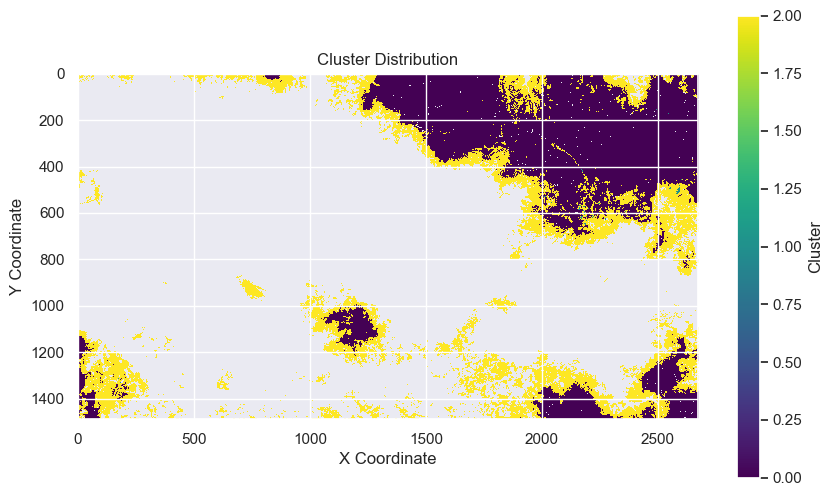

In [12]:
# Plot the Exported Raster
# Note: We're using a masked array to handle the nodata values correctly in the plot
masked_grid = np.ma.masked_where(grid == -9999, grid)

plt.figure(figsize=(10, 6))
plt.imshow(masked_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Cluster')
plt.title('Cluster Distribution')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()